""

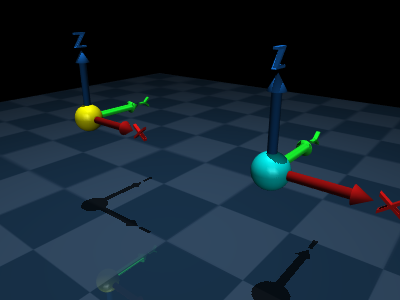

In [14]:
# Definition of the model in the mujoco framework and rendering of a picture

import mujoco
import mediapy as media

# Make model and data
model = mujoco.MjModel.from_xml_path('3D Gizmos.xml')
data = mujoco.MjData(model)

# Make renderer, render and show the pixels
with mujoco.Renderer(model, width=400, height=300) as renderer:
    mujoco.mj_forward(model, data)
    renderer.update_scene(data, camera="closeup")
    media.show_image(renderer.render())

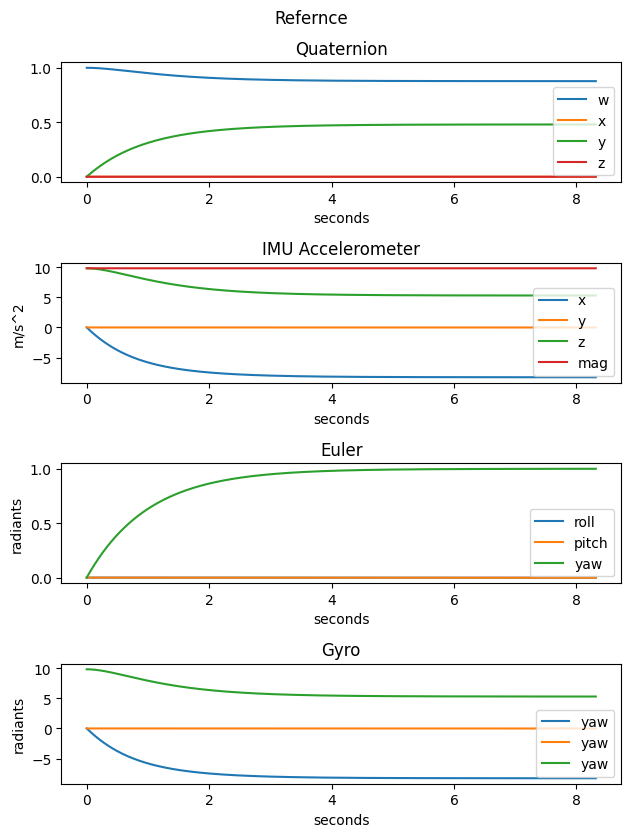

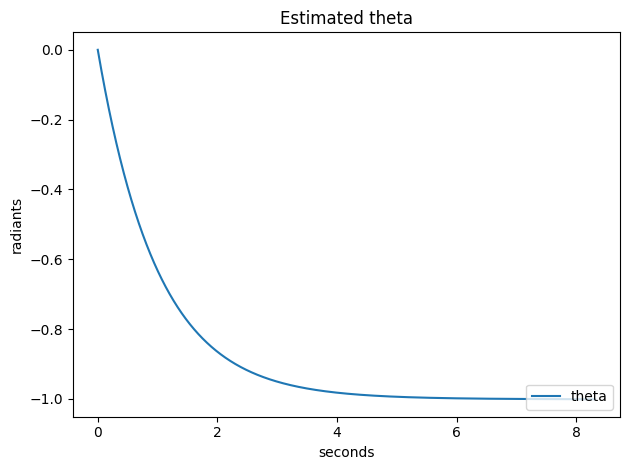

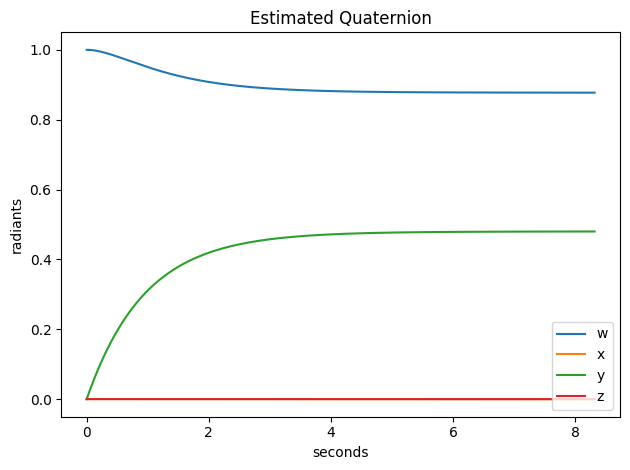

In [10]:
# Animation of the RED cube

from utils import *
import numpy as np
import matplotlib.pyplot as plt


def to_euler_angles(q):

    # roll (x-axis rotation)
    sinr_cosp = 2 * (q[0] * q[1] + q[2] * q[3])
    cosr_cosp = 1 - 2 * (q[1] * q[1] + q[2] * q[2])
    pitch = np.atan2(sinr_cosp, cosr_cosp)

    # pitch (y-axis rotation)
    sinp = np.sqrt(1 + 2 * (q[0] * q[2] - q[1] * q[3]))
    cosp = np.sqrt(1 - 2 * (q[0] * q[2] - q[1] * q[3]))
    yaw = 2 * np.atan2(sinp, cosp) - np.pi / 2

    # yaw (z-axis rotation)
    siny_cosp = 2 * (q[0] * q[3] + q[1] * q[2])
    cosy_cosp = 1 - 2 * (q[2] * q[2] + q[3] * q[3])
    #yaw = np.atan2(siny_cosp, cosy_cosp)
    roll = np.atan2(siny_cosp, cosy_cosp)

    return [roll, pitch, yaw]


class IMU:

    def __init__(self):
        pass
    
    def update_estimation(self, acc):
        up = [0, 0, 1]
        #l = np.linalg.norm(acc)
        #cos_theta = np.dot(acc, up) / l
        #n_sin_theta = np.cross(acc, up) / l
        #q = [(cos_theta + 1)/2, n_sin_theta[0]/2, n_sin_theta[1]/2, n_sin_theta[2]/2]
        #return q / np.linalg.norm(q)


        # Compute only angle
        th = np.arcsin(acc[0]/np.linalg.norm(acc))

        #########################à



        def orthogonal(v):
            x = np.abs(v[0])
            y = np.abs(v[1])
            z = np.abs(v[2])

            X_AXIS = [1, 0, 0]
            Y_AXIS = [0, 1, 0]
            Z_AXIS = [0, 0, 1]
            other = (X_AXIS if x < z else Z_AXIS) if x < y else (Y_AXIS if y < z else Z_AXIS)
            c = np.cross(v, other)
            return c / np.linalg.norm(c)


        k_cos_theta = np.dot(acc, up)
        k = np.linalg.norm(acc)

        #if (k_cos_theta / k + 1) ** 2 < 0.00000000001:
        if k_cos_theta / k == -1:
            o = orthogonal(acc)
            return [0, o[0], o[1], o[2]], th

        c = np.cross(acc, up)
        q = [(k_cos_theta + k) / 2, c[0] / 2, c[1] / 2, c[2] / 2]
        return q / np.linalg.norm(q), th
    

        # Angle estimation using the accelerometer
        acc_mag = np.linalg.norm(acc)
        #roll = np.arcsin(acc[1] / acc_mag)
        #pitch = -np.arcsin(acc[2] / acc_mag)
        #yaw = 0

        #accel = accel_x, accel_y, accel_z
        ref = np.array([0, 0, 1])
        acceln = acc / np.linalg.norm(acc)
        axis = np.cross(acceln, ref)
        angle = np.arccos(np.dot(acceln, ref))
        orientation = self.quaternion_about_axis(angle, axis)
        return to_euler_angles(orientation), orientation

        #roll = signed_angle_between(acc, [0, 0, 1], [1, 0, 0])
        #pitch = signed_angle_between(acc, [0, 0, 1], [0, 1, 0])
        #yaw = 0
        #return [roll, pitch, yaw]
    

    
    def quaternion_about_axis(self, angle, axis):
        s = np.sin(angle)
        return [np.cos(angle), s*axis[0], s*axis[1], s*axis[2]]
        


def main():
    times = []
    qpos = []
    euler = []
    acc = []
    imu_est = []
    qest = []
    gyro = []

    imu = IMU()


    # This function is called once when the simulation is initialized
    # Here we initialize the state of the simulation
    def sim_init(data):
       # data.joint('center').qpos = [np.cos(theta0/2), 0, np.sin(theta0/2), 0]
       data.joint('master_center').qvel = [0, 1, 0]
       pass


    # This function is called for every simulation loop
    # Here we read sensor data and drive the actuators
    def sim_loop(data):
        # Read Sensors
        #data.joint('center').qpos = [np.cos(theta0/2), 0, np.sin(theta0/2), 0]
        q = data.joint('master_center').qpos.copy()
        a = data.sensor('accelerometer').data.copy()
        g = data.sensor('gyro').data.copy()
        qe, ee = imu.update_estimation(a)
        # Store Signals
        times.append(data.time)
        qpos.append(q)
        euler.append(to_euler_angles(q))
        acc.append([a[0], a[1], a[2], np.linalg.norm(a)])
        imu_est.append(ee)
        qest.append(qe)
        gyro.append(g)

        data.joint('master_center').qvel = data.joint('master_center').qvel * 0.999


    # Run the simulation
    run_simulation(
            xml_model = '3D Gizmos.xml',
            n_frames = 500,
            fps = 60.0,
            width=320,
            height=240,
            sim_init_calback=sim_init,
            sim_loop_calback=sim_loop
    )


    # Plot mujoco simulation
    fig, axs = plt.subplots(4)
    # Plot quaternion
    axs[0].plot(np.asarray(times), np.asarray([x[0] for x in qpos]), label="w")
    axs[0].plot(np.asarray(times), np.asarray([x[1] for x in qpos]), label="x")
    axs[0].plot(np.asarray(times), np.asarray([x[2] for x in qpos]), label="y")
    axs[0].plot(np.asarray(times), np.asarray([x[3] for x in qpos]), label="z")
    axs[0].set_xlabel('seconds')
    axs[0].legend(frameon=True, loc='lower right')
    axs[0].title.set_text('Quaternion')
    # Plot accelerometer
    axs[1].plot(np.asarray(times), np.asarray([x[0] for x in acc]), label="x")
    axs[1].plot(np.asarray(times), np.asarray([x[1] for x in acc]), label="y")
    axs[1].plot(np.asarray(times), np.asarray([x[2] for x in acc]), label="z")
    axs[1].plot(np.asarray(times), np.asarray([x[3] for x in acc]), label="mag")
    axs[1].set_ylabel('m/s^2')
    axs[1].set_xlabel('seconds')
    axs[1].legend(frameon=True, loc='lower right')
    axs[1].title.set_text('IMU Accelerometer')
    # Plot euler
    axs[2].plot(np.asarray(times), np.asarray([x[0] for x in euler]), label="roll")
    axs[2].plot(np.asarray(times), np.asarray([x[1] for x in euler]), label="pitch")
    axs[2].plot(np.asarray(times), np.asarray([x[2] for x in euler]), label="yaw")
    axs[2].set_ylabel('radiants')
    axs[2].set_xlabel('seconds')
    axs[2].legend(frameon=True, loc='lower right')
    axs[2].title.set_text('Euler')
    # Plot gyro
    #axs[3].plot(np.asarray(times), np.asarray([x[0] for x in euler]), label="roll")
    #axs[3].plot(np.asarray(times), np.asarray([x[1] for x in euler]), label="pitch")
    #axs[3].plot(np.asarray(times), np.asarray([x[2] for x in euler]), label="yaw")
    axs[3].plot(np.asarray(times), gyro, label="yaw")
    axs[3].set_ylabel('radiants')
    axs[3].set_xlabel('seconds')
    axs[3].legend(frameon=True, loc='lower right')
    axs[3].title.set_text('Gyro')
    fig.suptitle('Refernce')
    fig.set_size_inches(6.5, 8.5)
    plt.tight_layout()

    # Plot euler
    fig1, axs1 = plt.subplots()
    axs1.plot(np.asarray(times), imu_est, label="theta")
    axs1.set_ylabel('radiants')
    axs1.set_xlabel('seconds')
    axs1.legend(frameon=True, loc='lower right')
    axs1.title.set_text('Estimated theta')
    plt.tight_layout()

    # Plot estimate quaterinion
    fig2, axs2 = plt.subplots()
    axs2.plot(np.asarray(times), np.asarray([x[0] for x in qest]), label="w")
    axs2.plot(np.asarray(times), np.asarray([x[1] for x in qest]), label="x")
    axs2.plot(np.asarray(times), np.asarray([x[2] for x in qest]), label="y")
    axs2.plot(np.asarray(times), np.asarray([x[3] for x in qest]), label="z")
    axs2.set_ylabel('radiants')
    axs2.set_xlabel('seconds')
    axs2.legend(frameon=True, loc='lower right')
    axs2.title.set_text('Estimated Quaternion')
    plt.tight_layout()


if __name__=="__main__":
	main()